## **Second Attempt**

In [7]:
import numpy as np
import pandas as pd


train_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/train.csv')
test_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/test.csv')
sub_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/gender_submission.csv')

In [11]:
# Remove features that won't be used to make model
def delete_features(df):
    feature_list = ['PassengerId', 'Ticket', 'Cabin']
    df.drop(feature_list, axis = 1, inplace = True)


# Remove outlier data at Age
def remove_age(df):
    index = df[df['Age'] >= 80].index
    df = df.drop(index, axis = 0, inplace = False)


# Fill Null Value at train data
def fill_NaN_train(df):
    index_list = df[df['Age'].isna() == 1].index.tolist()
    for index in index_list:
        Pclass = df[df.index == index]['Pclass'].values.tolist()[0]
        if Pclass == 1:
            df['Age'][index] = df[df['Pclass'] == 1].loc[:,'Age'].mean()
        elif Pclass == 2:
            df['Age'][index] = df[df['Pclass'] == 2].loc[:,'Age'].mean()
        else:
            df['Age'][index] = df[df['Pclass'] == 3].loc[:,'Age'].mean()

    df['Embarked'] = df['Embarked'].fillna('C')

# Fill Null Value at train test
def fill_NaN_test(df):
    index_list = df[df['Age'].isna() == 1].index.tolist()
    for index in index_list:
        Pclass = df[df.index == index]['Pclass'].values.tolist()[0]
        if Pclass == 1:
            df['Age'][index] = df[df['Pclass'] == 1].loc[:,'Age'].mean()
        elif Pclass == 2:
            df['Age'][index] = df[df['Pclass'] == 2].loc[:,'Age'].mean()
        else:
            df['Age'][index] = df[df['Pclass'] == 3].loc[:,'Age'].mean()
            
    df['Fare'][152] = 28.230436


# Extract title from Name, remove titles that not exist in test data and do encoding at train data
def Name_Engineering_train(df):
    Title_list = list()
    for str in df['Name']:
        str1 = str.split(', ')[1]
        str2 = str1.split('.')[0]
        Title_list.append(str2)

    df['Title'] = Title_list
    drop_title = ['Mlle', 'Major', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
    drop_index = list()
    for title in drop_title:
        index = df[df['Title'] == title].index.tolist()
        drop_index.append(index)
    drop_index = sum(drop_index,[])
    df.drop(drop_index, axis = 0, inplace = True)
    
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_title = label.fit_transform(df['Title'])
    df['Title'] = new_title
    df.drop('Name', axis = 1, inplace = True)

# Extract title from Name and do encoding at test data
def Name_Engineering_test(df):
    Title_list = list()
    for str in df['Name']:
        str1 = str.split(', ')[1]
        str2 = str1.split('.')[0]
        Title_list.append(str2)
        
    # Dona index = 414 change Dona to ZDona for last labeling (not in train set)
    Title_list[414] = 'ZDona'
    
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_title = label.fit_transform(Title_list)
    df['Title'] = new_title
    df.drop('Name', axis = 1, inplace = True)


# Encoding the Sex feature
def Sex_Encoding(df):
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_sex = label.fit_transform(df['Sex'])
    df['Sex'] = new_sex


# Transform continous data to 9 selections and Encoding
def Age_Engineering(df):
    def Age_Conversion(age):
        title = ''
        if age <= 5:
            title = 'Baby'
        elif age <= 16:
            title = 'Child'
        elif age <= 32:
            title = 'Young_Adult'
        elif age <= 48:
            title = 'Adult'
        elif age <= 64:
            title = 'Old_Adult'
        else:
            title = 'Senior'

        return title

    df['Age_selection'] = df['Age'].apply(lambda x : Age_Conversion(x))
    df.drop('Age', axis = 1, inplace = True)

    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_age = label.fit_transform(df['Age_selection'])
    df['Age_selection'] = new_age


# Combine SibSp feature and Parch feature to make Family new feature
def Family_Conversion(df):
    df['Family'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)


# Do log conversion on Fare feature to reduce right skewness
def Fare_Log(df):
    df['Fare'] = np.log1p(df['Fare'])


# Encoding Embarked feature
def Embarked_Encoding(df):
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_embarked = label.fit_transform(df['Embarked'])
    df['Embarked'] = new_embarked

In [12]:
def Feature_Engineering_train(df):
    delete_features(df)
    remove_age(df)
    fill_NaN_train(df)
    Name_Engineering_train(df)
    Sex_Encoding(df)
    Age_Engineering(df)
    Family_Conversion(df)
    Fare_Log(df)
    Embarked_Encoding(df)

def Feature_Engineering_test(df):
    delete_features(df)
    fill_NaN_test(df)
    Name_Engineering_test(df)
    Sex_Encoding(df)
    Age_Engineering(df)
    Family_Conversion(df)
    Fare_Log(df)
    Embarked_Encoding(df)

In [13]:
import warnings
warnings.filterwarnings(action='ignore')

Feature_Engineering_train(train_df)
Feature_Engineering_test(test_df)

In [14]:
Feature = train_df.drop('Survived', axis = 1, inplace = False)
Label = train_df['Survived']

### **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rdf_model = RandomForestClassifier(random_state = 0)

score_list = cross_val_score(rdf_model, Feature, Label, scoring = 'accuracy', cv =5)

print("튜닝전 Random Forest Model 검증 정확도 : ", np.mean(score_list))

튜닝전 Random Forest Model 검증 정확도 :  0.8056818181818182


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [ i for i in range(2,11) ] }

rdf_model = RandomForestClassifier(random_state = 0)

tune_rdf = GridSearchCV(rdf_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_rdf.fit(Feature, Label)

result_df = pd.DataFrame(tune_rdf.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))

print("튜닝후 Random Forest Model 검증 정확도 : ", tune_rdf.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.260329,0.014937,0.008386,0.007183,5,{'max_depth': 5},0.812500,0.829545,0.829545,0.806818,0.846591,0.825000,0.014102,1
2,0.241789,0.010955,0.004234,0.006088,4,{'max_depth': 4},0.846591,0.818182,0.818182,0.806818,0.829545,0.823864,0.013446,2
7,0.269901,0.006962,0.015625,0.000054,9,{'max_depth': 9},0.812500,0.812500,0.857955,0.789773,0.846591,0.823864,0.024896,2
4,0.259636,0.007415,0.005730,0.007168,6,{'max_depth': 6},0.806818,0.818182,0.835227,0.806818,0.835227,0.820455,0.012756,4
6,0.279325,0.005242,0.008647,0.007305,8,{'max_depth': 8},0.823864,0.801136,0.835227,0.789773,0.840909,0.818182,0.019682,5
8,0.276287,0.007360,0.011414,0.008993,10,{'max_depth': 10},0.801136,0.806818,0.846591,0.778409,0.840909,0.814773,0.025562,6
1,0.240848,0.005991,0.006249,0.007653,3,{'max_depth': 3},0.818182,0.823864,0.806818,0.795455,0.812500,0.811364,0.009775,7
5,0.263897,0.011416,0.016774,0.006419,7,{'max_depth': 7},0.772727,0.812500,0.823864,0.801136,0.835227,0.809091,0.021441,8
0,0.230370,0.020331,0.012500,0.004747,2,{'max_depth': 2},0.818182,0.818182,0.806818,0.755682,0.789773,0.797727,0.023454,9


튜닝후 Random Forest Model 검증 정확도 :  0.825


In [17]:
prediction = tune_rdf.predict(test_df)

In [18]:
submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**score** : 0.76076

**Apply Feature Selection**

<Axes: ylabel='None'>

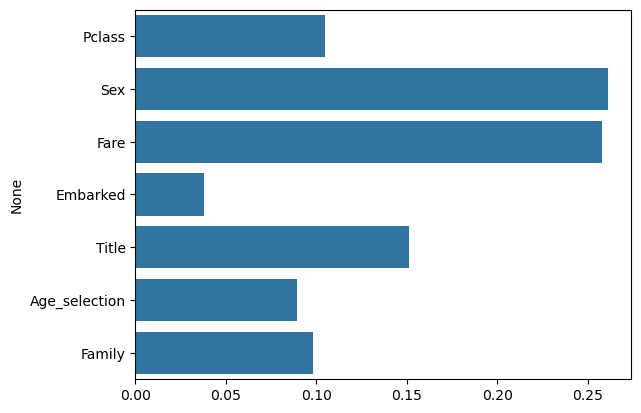

In [10]:
import seaborn as sns
importance = tune_rdf.best_estimator_.feature_importances_
sns.barplot(x = importance, y = Feature.columns)

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

print("이전 feautre :", Feature.columns.tolist())

rdf_model = RandomForestClassifier(random_state = 0)
rfe_model = RFECV(rdf_model, cv = 5, scoring = 'accuracy')
rfe_model.fit(Feature, Label)

rfe_model.support_

이전 feautre : ['Pclass', 'Sex', 'Fare', 'Embarked', 'Title', 'Age_selection', 'Family']


array([ True,  True,  True, False,  True,  True,  True])

In [49]:
# drop Embarked
drop_train = Feature.drop(['Embarked'], axis = 1, inplace = False)
drop_test = test_df.drop(['Embarked'], axis = 1, inplace = False)

# tuning parameter and get result
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [ i for i in range(2,11) ] }

rdf_model = RandomForestClassifier(random_state = 0)

tune_rdf = GridSearchCV(rdf_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_rdf.fit(drop_train, Label)

result_df = pd.DataFrame(tune_rdf.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.239376,0.006035,0.009393,0.007670,4,{'max_depth': 4},0.846591,0.823864,0.823864,0.806818,0.852273,0.830682,0.016624,1
5,0.195484,0.006049,0.009522,0.006271,7,{'max_depth': 7},0.829545,0.812500,0.852273,0.823864,0.835227,0.830682,0.013154,1
6,0.195525,0.008055,0.012227,0.006144,8,{'max_depth': 8},0.818182,0.818182,0.852273,0.812500,0.852273,0.830682,0.017751,1
3,0.205392,0.036371,0.016565,0.002157,5,{'max_depth': 5},0.835227,0.835227,0.823864,0.801136,0.852273,0.829545,0.016855,4
7,0.197111,0.011799,0.006409,0.006057,9,{'max_depth': 9},0.812500,0.823864,0.857955,0.795455,0.852273,0.828409,0.023673,5
1,0.181401,0.054053,0.009430,0.007699,3,{'max_depth': 3},0.835227,0.823864,0.812500,0.795455,0.835227,0.820455,0.015076,6
4,0.188089,0.009982,0.012812,0.006435,6,{'max_depth': 6},0.818182,0.818182,0.829545,0.795455,0.840909,0.820455,0.015076,6
8,0.206044,0.004336,0.017033,0.006929,10,{'max_depth': 10},0.823864,0.823864,0.840909,0.778409,0.835227,0.820455,0.022035,6
0,0.134597,0.031533,0.007516,0.007223,2,{'max_depth': 2},0.818182,0.818182,0.784091,0.755682,0.789773,0.793182,0.023454,9


In [50]:
prediction = tune_rdf.predict(drop_test)

submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**score** : 0.77990

### **Xgboost**

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(random_state = 0, n_estimaotrs = 100, max_depth = 6)

score_list = cross_val_score(xgb_model, Feature, Label, scoring = 'accuracy', cv = 5)

print("튜닝전 XGBoost 모델 검증 정확도 : ", np.mean(score_list))

튜닝전 XGBoost 모델 검증 정확도 :  0.8136363636363637


In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Find optimal max_depth
params = {'max_depth' : [ i for i in range(2,11) ] }

xgb_model = XGBClassifier(random_state = 0, learning_rate = 0.3)

tune_xgb = GridSearchCV(xgb_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_xgb.fit(Feature, Label)

result_df = pd.DataFrame(tune_xgb.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))
print("Best Parameter : ", tune_xgb.best_params_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068811,0.006748,0.001855,0.002288,2,{'max_depth': 2},0.823864,0.846591,0.846591,0.835227,0.835227,0.837500,0.008504,1
2,0.088176,0.003737,0.008520,0.005437,4,{'max_depth': 4},0.829545,0.789773,0.852273,0.818182,0.852273,0.828409,0.023399,2
1,0.067672,0.013370,0.029173,0.050852,3,{'max_depth': 3},0.829545,0.801136,0.846591,0.812500,0.835227,0.825000,0.016231,3
3,0.096386,0.010727,0.009644,0.007894,5,{'max_depth': 5},0.812500,0.795455,0.852273,0.806818,0.857955,0.825000,0.025257,3
5,0.136660,0.008978,0.001202,0.002404,7,{'max_depth': 7},0.812500,0.806818,0.852273,0.789773,0.846591,0.821591,0.023999,5
7,0.166783,0.007688,0.004761,0.005770,9,{'max_depth': 9},0.812500,0.806818,0.852273,0.801136,0.835227,0.821591,0.019218,5
6,0.154844,0.012106,0.003732,0.006062,8,{'max_depth': 8},0.812500,0.784091,0.846591,0.812500,0.846591,0.820455,0.023728,7
4,0.120336,0.012432,0.002625,0.004711,6,{'max_depth': 6},0.806818,0.795455,0.829545,0.795455,0.840909,0.813636,0.018464,8
8,0.180374,0.017137,0.007405,0.006867,10,{'max_depth': 10},0.812500,0.795455,0.840909,0.778409,0.823864,0.810227,0.021740,9


Best Parameter :  {'max_depth': 2}


In [22]:
# Find optimal learning rate by bayesian hyper tuning
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

xgb_search_space = {'learning_rate' : hp.uniform('learning_rate', 0.01, 0.1)}

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective_func(search_space):
    xgb_model = XGBClassifier(random_state = 0, max_depth = 4, learning_rate = search_space['learning_rate'])

    score_list = cross_val_score(xgb_model, Feature, Label, scoring = 'accuracy', cv = 5)

    return {'loss' : -1 * np.mean(score_list), 'status' : STATUS_OK}

In [28]:
trials = Trials()

best_learning_rate = fmin(fn = objective_func, space = xgb_search_space, algo = tpe.suggest, max_evals = 50, trials = trials)
print("Best learning_rate : ", best_learning_rate['learning_rate'])

100%|███████████████████████████████████████████████| 50/50 [00:23<00:00,  2.17trial/s, best loss: -0.8431818181818181]
Best learning_rate :  0.03594716553005606


In [29]:
# train model
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(random_state = 0, max_depth = 4, learning_rate = 0.03594716553005606)

score_list = cross_val_score(xgb_model, Feature, Label, scoring = 'accuracy', cv = 5)

print("튜닝후 XGB 모델 검증 정확도 : ", np.mean(score_list))

튜닝후 XGB 모델 검증 정확도 :  0.8431818181818181


In [30]:
xgb_model.fit(Feature, Label)
prediction = xgb_model.predict(test_df)

submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**score** : 0.76794

**Apply Feature Selection**

In [43]:
drop_train = Feature.drop(['Embarked'], axis = 1, inplace = False)
drop_test = test_df.drop(['Embarked'], axis = 1, inplace = False)

# tuning parameter and get result
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [ i for i in range(2,11) ] }

xgb_model = XGBClassifier(random_state = 0)

tune_xgb = GridSearchCV(xgb_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_xgb.fit(drop_train, Label)

result_df = pd.DataFrame(tune_xgb.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.083847,0.006892,0.008115,0.007040,4,{'max_depth': 4},0.840909,0.812500,0.869318,0.840909,0.846591,0.842045,0.018111,1
0,0.065643,0.009387,0.001800,0.002227,2,{'max_depth': 2},0.835227,0.835227,0.846591,0.835227,0.840909,0.838636,0.004545,2
1,0.067523,0.006433,0.008712,0.007368,3,{'max_depth': 3},0.818182,0.812500,0.857955,0.835227,0.840909,0.832955,0.016310,3
3,0.099829,0.006965,0.006271,0.007681,5,{'max_depth': 5},0.835227,0.806818,0.846591,0.823864,0.846591,0.831818,0.015076,4
4,0.112555,0.003049,0.001401,0.002802,6,{'max_depth': 6},0.835227,0.795455,0.852273,0.818182,0.852273,0.830682,0.021680,5
5,0.135430,0.011884,0.006575,0.006920,7,{'max_depth': 7},0.806818,0.818182,0.857955,0.806818,0.840909,0.826136,0.020200,6
8,0.189703,0.009643,0.003125,0.006251,10,{'max_depth': 10},0.829545,0.812500,0.823864,0.784091,0.835227,0.817045,0.018111,7
6,0.142496,0.009765,0.008804,0.007286,8,{'max_depth': 8},0.818182,0.784091,0.835227,0.801136,0.829545,0.813636,0.018810,8
7,0.166647,0.009611,0.013715,0.002508,9,{'max_depth': 9},0.818182,0.801136,0.812500,0.795455,0.840909,0.813636,0.015828,8


In [44]:
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials

xgb_search_space = {'learning_rate' : hp.uniform('learning_rate', 0.01, 0.1)}

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective_func(search_space):
    xgb_model = XGBClassifier(random_state = 0, max_depth = 4, learning_rate = search_space['learning_rate'])

    score_list = cross_val_score(xgb_model, drop_train, Label, scoring = 'accuracy', cv = 5)

    return {'loss' : -1 * np.mean(score_list), 'status' : STATUS_OK}

In [46]:
trials = Trials()

best_learning_rate = fmin(fn = objective_func, space = xgb_search_space, algo = tpe.suggest, max_evals = 50, trials = trials)
print("Best learning_rate : ", best_learning_rate['learning_rate'])

100%|███████████████████████████████████████████████| 50/50 [00:23<00:00,  2.15trial/s, best loss: -0.8431818181818181]
Best learning_rate :  0.05942538544642277


In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(random_state = 0, max_depth = 4, learning_rate = 0.05942538544642277)

score_list = cross_val_score(xgb_model, drop_train, Label, scoring = 'accuracy', cv = 5)

print("튜닝후 XGB 모델 검증 정확도 : ", np.mean(score_list))

튜닝후 XGB 모델 검증 정확도 :  0.8431818181818181


In [48]:
xgb_model.fit(drop_train, Label)
prediction = xgb_model.predict(drop_test)

submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**결론**

9천등대 -> 2177등

할 수 있는 것들

1. Fare의 selection을 통한 category화 - age를 category화 한 결과 성능이 향상 됨
2. 단순 모델 사용하는 것이 아닌 voting으로 성능을 좀 더 높이기

**Fare selection**

<Axes: xlabel='Fare', ylabel='Count'>

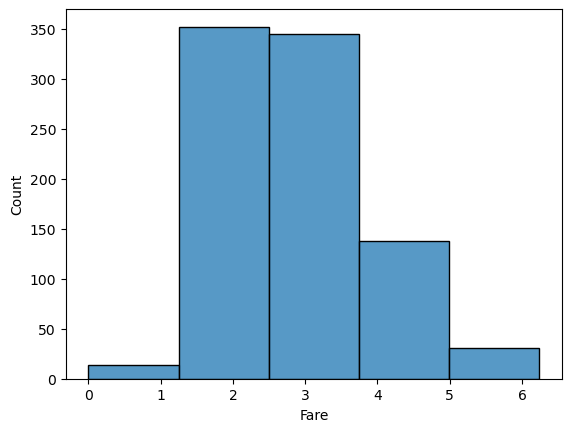

In [6]:
import seaborn as sns

sns.histplot(x = train_df['Fare'], bins = 5)

In [6]:
def Fare_Log_Selection(df):
    def Fare_Conversion(x):
        title =''
        if x < 1.2:
            title = 'level1'
        elif x < 2.5:
            title = 'level2'
        elif x < 3.7:
            title = 'level3'
        elif x < 5:
            title = 'level4'
        else:
            title = 'level5'
        return title

    df['Fare_Selection'] = df['Fare'].apply(lambda x : Fare_Conversion(x))
    df.drop('Fare', axis = 1, inplace = True)

    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['Fare_Selection'] = label.fit_transform(df['Fare_Selection'])

In [7]:
Fare_Log_Selection(train_df)
Fare_Log_Selection(test_df)
Feature = train_df.drop('Survived', axis = 1, inplace = False)
Label = train_df['Survived']

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rdf_model = RandomForestClassifier(random_state = 0)

score_list = cross_val_score(rdf_model, Feature, Label, scoring = 'accuracy', cv =5)

print("튜닝전 Random Forest Model 검증 정확도 : ", np.mean(score_list))

튜닝전 Random Forest Model 검증 정확도 :  0.8125


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [ i for i in range(2,11) ] }

rdf_model = RandomForestClassifier(random_state = 0)

tune_rdf = GridSearchCV(rdf_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_rdf.fit(Feature, Label)

result_df = pd.DataFrame(tune_rdf.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))

print("튜닝후 Random Forest Model 검증 정확도 : ", tune_rdf.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.175405,0.002831,0.012495,0.006248,5,{'max_depth': 5},0.812500,0.818182,0.818182,0.801136,0.869318,0.823864,0.023564,1
4,0.173741,0.001267,0.012221,0.006175,6,{'max_depth': 6},0.812500,0.823864,0.818182,0.795455,0.863636,0.822727,0.022556,2
5,0.183341,0.008386,0.012485,0.006243,7,{'max_depth': 7},0.806818,0.784091,0.846591,0.795455,0.857955,0.818182,0.028972,3
6,0.185774,0.006560,0.009268,0.007571,8,{'max_depth': 8},0.801136,0.784091,0.852273,0.784091,0.852273,0.814773,0.031245,4
8,0.189505,0.007098,0.008649,0.007184,10,{'max_depth': 10},0.772727,0.784091,0.852273,0.801136,0.852273,0.812500,0.033710,5
7,0.186859,0.009708,0.012346,0.006180,9,{'max_depth': 9},0.772727,0.778409,0.852273,0.801136,0.852273,0.811364,0.034729,6
1,0.127356,0.007911,0.004311,0.006150,3,{'max_depth': 3},0.801136,0.823864,0.801136,0.806818,0.818182,0.810227,0.009232,7
2,0.171812,0.011095,0.007594,0.007929,4,{'max_depth': 4},0.812500,0.812500,0.795455,0.801136,0.829545,0.810227,0.011700,7
0,0.130947,0.030450,0.003786,0.006050,2,{'max_depth': 2},0.750000,0.806818,0.795455,0.784091,0.806818,0.788636,0.021076,9


튜닝후 Random Forest Model 검증 정확도 :  0.8238636363636365


In [10]:
prediction = tune_rdf.predict(test_df)

submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**score** : 0.77511

**결론**

log변환으로도 충분히 분류가 되는 듯 하다

Age 범위 조정 + voting형식으로 성능 더 올려보기

**Extra** : OHE Encoding을 해서 유의미한 증가가 있는 지 확인해보자

In [51]:
import numpy as np
import pandas as pd


train_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/train.csv')
test_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/test.csv')
sub_df = pd.read_csv('C:/Users/user/Desktop/Study/Kaggle/Titanic/Data_File/gender_submission.csv')

In [52]:
# Remove features that won't be used to make model
def delete_features(df):
    feature_list = ['PassengerId', 'Ticket', 'Cabin']
    df.drop(feature_list, axis = 1, inplace = True)


# Remove outlier data at Age
def remove_age(df):
    index = df[df['Age'] >= 80].index
    df = df.drop(index, axis = 0, inplace = False)


# Fill Null Value at train data
def fill_NaN_train(df):
    index_list = df[df['Age'].isna() == 1].index.tolist()
    for index in index_list:
        Pclass = df[df.index == index]['Pclass'].values.tolist()[0]
        if Pclass == 1:
            df['Age'][index] = df[df['Pclass'] == 1].loc[:,'Age'].mean()
        elif Pclass == 2:
            df['Age'][index] = df[df['Pclass'] == 2].loc[:,'Age'].mean()
        else:
            df['Age'][index] = df[df['Pclass'] == 3].loc[:,'Age'].mean()

    df['Embarked'] = df['Embarked'].fillna('C')

# Fill Null Value at train test
def fill_NaN_test(df):
    index_list = df[df['Age'].isna() == 1].index.tolist()
    for index in index_list:
        Pclass = df[df.index == index]['Pclass'].values.tolist()[0]
        if Pclass == 1:
            df['Age'][index] = df[df['Pclass'] == 1].loc[:,'Age'].mean()
        elif Pclass == 2:
            df['Age'][index] = df[df['Pclass'] == 2].loc[:,'Age'].mean()
        else:
            df['Age'][index] = df[df['Pclass'] == 3].loc[:,'Age'].mean()
            
    df['Fare'][152] = 28.230436


# Extract title from Name, remove titles that not exist in test data
def Name_Engineering_train(df):
    Title_list = list()
    for str in df['Name']:
        str1 = str.split(', ')[1]
        str2 = str1.split('.')[0]
        Title_list.append(str2)

    df['Title'] = Title_list
    drop_title = ['Mlle', 'Major', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
    drop_index = list()
    for title in drop_title:
        index = df[df['Title'] == title].index.tolist()
        drop_index.append(index)
    drop_index = sum(drop_index,[])
    df.drop(drop_index, axis = 0, inplace = True)
    df.drop('Name', axis = 1, inplace = True)

# Extract title from Name
def Name_Engineering_test(df):
    Title_list = list()
    for str in df['Name']:
        str1 = str.split(', ')[1]
        str2 = str1.split('.')[0]
        Title_list.append(str2)
    df['Title'] = Title_list
    df.drop('Name', axis = 1, inplace = True)

# Encoding the Sex feature
def Sex_Encoding(df):
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    new_sex = label.fit_transform(df['Sex'])
    df['Sex'] = new_sex


# Transform continous data to 9 selections and Encoding
def Age_Engineering(df):
    def Age_Conversion(age):
        title = ''
        if age <= 5:
            title = 'Baby'
        elif age <= 10:
            title = 'Baby_Child'
        elif age <= 16:
            title = 'Child'
        elif age <= 28:
            title = 'Young_Adult'
        elif age <= 36:
            title = 'OB'
        elif age <= 44:
            title = 'Adult'
        elif age <= 52:
            title = 'Old_Adult'
        elif age <= 64:
            title = 'Senior'
        else:
            title = 'Grand'

        return title

    df['Age_selection'] = df['Age'].apply(lambda x : Age_Conversion(x))
    df.drop('Age', axis = 1, inplace = True)


# Combine SibSp feature and Parch feature to make Family new feature
def Family_Conversion(df):
    df['Family'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)


# Do log conversion on Fare feature to reduce right skewness
def Fare_Log(df):
    df['Fare'] = np.log1p(df['Fare'])

In [53]:
def Feature_Engineering_train(df):
    delete_features(df)
    remove_age(df)
    fill_NaN_train(df)
    Name_Engineering_train(df)
    Sex_Encoding(df)
    Age_Engineering(df)
    Family_Conversion(df)
    Fare_Log(df)
    #Embarked_Encoding(df)

def Feature_Engineering_test(df):
    delete_features(df)
    fill_NaN_test(df)
    Name_Engineering_test(df)
    Sex_Encoding(df)
    Age_Engineering(df)
    Family_Conversion(df)
    Fare_Log(df)
    #Embarked_Encoding(df)

In [54]:
import warnings
warnings.filterwarnings(action='ignore')

Feature_Engineering_train(train_df)
Feature_Engineering_test(test_df)

In [55]:
train_df = pd.get_dummies(train_df, columns = ['Embarked', 'Title', 'Age_selection'])
test_df = pd.get_dummies(test_df, columns = ['Embarked', 'Title', 'Age_selection'])

In [57]:
test_df.drop('Title_Dona', axis = 1, inplace = True)

In [58]:
Feature = train_df.drop('Survived', axis = 1, inplace = False)
Label = train_df['Survived']

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [ i for i in range(2,11) ] }

rdf_model = RandomForestClassifier(random_state = 0)

tune_rdf = GridSearchCV(rdf_model, param_grid = params, cv = 5, scoring = 'accuracy', refit = True)
tune_rdf.fit(Feature, Label)

result_df = pd.DataFrame(tune_rdf.cv_results_)
display(result_df.sort_values(by = 'mean_test_score', ascending = False))

print("튜닝후 Random Forest Model 검증 정확도 : ", tune_rdf.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.186218,0.010425,0.010204,0.008070,6,{'max_depth': 6},0.846591,0.829545,0.823864,0.801136,0.852273,0.830682,0.018111,1
5,0.193220,0.007254,0.007305,0.007442,7,{'max_depth': 7},0.823864,0.840909,0.846591,0.789773,0.852273,0.830682,0.022556,1
3,0.169967,0.006677,0.015711,0.000044,5,{'max_depth': 5},0.846591,0.829545,0.818182,0.789773,0.857955,0.828409,0.023673,3
6,0.221590,0.023082,0.019035,0.009651,8,{'max_depth': 8},0.829545,0.829545,0.840909,0.778409,0.840909,0.823864,0.023289,4
2,0.177751,0.006589,0.013807,0.004108,4,{'max_depth': 4},0.840909,0.823864,0.812500,0.784091,0.835227,0.819318,0.020136,5
7,0.226243,0.023224,0.017174,0.002327,9,{'max_depth': 9},0.812500,0.812500,0.840909,0.784091,0.835227,0.817045,0.020136,6
8,0.202740,0.002500,0.015854,0.000284,10,{'max_depth': 10},0.812500,0.795455,0.852273,0.795455,0.823864,0.815909,0.021138,7
1,0.130325,0.025966,0.010281,0.007128,3,{'max_depth': 3},0.835227,0.823864,0.789773,0.767045,0.795455,0.802273,0.024478,8
0,0.142823,0.024459,0.008671,0.007206,2,{'max_depth': 2},0.806818,0.829545,0.778409,0.755682,0.784091,0.790909,0.025257,9


튜닝후 Random Forest Model 검증 정확도 :  0.8306818181818182


In [61]:
prediction = tune_rdf.predict(test_df)

submission = pd.DataFrame({
"PassengerId":sub_df['PassengerId'],
"Survived": prediction
})
display(submission)

submission.to_csv('submission.csv',index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
